## Load replay buffer

In [1]:
import pickle
import torch
from src.utils import load_replay_buffer
from src.learning.symmetry_discovery.differential.kernel_approx import KernelFrameEstimator

TASK_NAME="sac_circle_rotation_task_0"
N_SAMPLES:int=50_000
KERNEL_DIM=1
EPSILON_BALL = 0.005
EPSILON_LEVEL_SET = 0.0025

LEARN_KERNEL_BASES: bool=False
replay_buffer_name:str=TASK_NAME+"_replay_buffer.pkl"
kernel_bases_name:str=TASK_NAME+"_kernel_bases.pkl"

replay_buffer_task_1= load_replay_buffer(replay_buffer_name, N_steps=N_SAMPLES)

next_ps=replay_buffer_task_1["next_observations"]
ns=replay_buffer_task_1["rewards"]



if LEARN_KERNEL_BASES:
    frameestimator= KernelFrameEstimator(ps=next_ps, kernel_dim=KERNEL_DIM,ns=ns, epsilon_ball=EPSILON_BALL, epsilon_level_set=EPSILON_LEVEL_SET)
    frameestimator.compute()
    frameestimator.save(kernel_bases_name)

else:
    # for inference only need ps and dimension of kernel.
    frameestimator=KernelFrameEstimator(ps=next_ps, kernel_dim=KERNEL_DIM)
    with open(kernel_bases_name, 'rb') as f:
        kernel_samples = pickle.load(f)
        frameestimator.set_frame(frame=kernel_samples)

# Evaluate frame estimator
p_query=torch.randn((1,2))
frameestimator.evaluate(p_query, bandwidth=0.05)

2025-07-02 14:34:38.610236: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:faiss.loader:Loading faiss.
INFO:faiss.loader:Successfully loaded faiss.
INFO:faiss:Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes. This is only an error if you're trying to use GPU Faiss.
/Users/paulnitschke/Desktop/projects/geo_meta_rl/src/utils.py:68: UserWarning: Replay buffer contains more samples than selected.
  warnings.warn("Replay buffer contains more samples than selected.")
INFO:root:Setup kernel frame evaluation.


tensor([[[-0.7880],
         [ 0.6157]]])

## Extrapolate via KDE

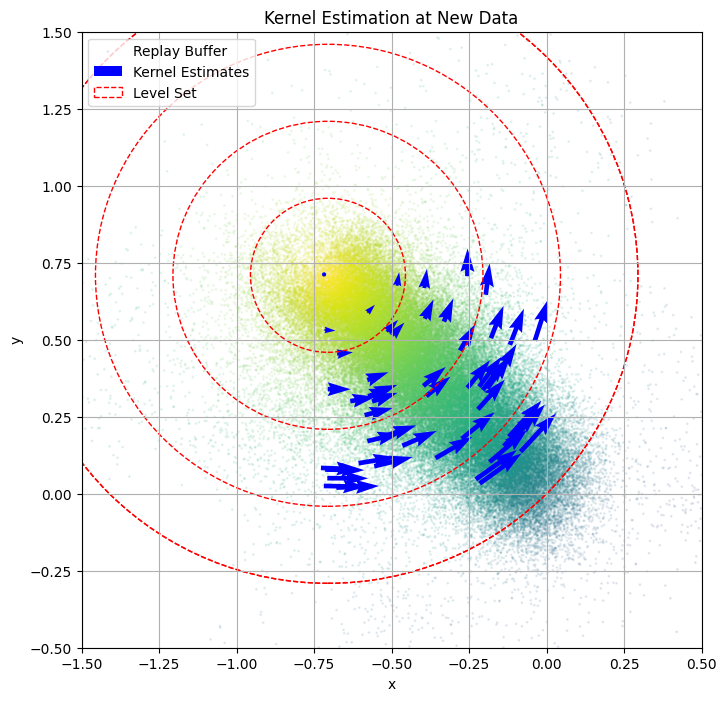

In [11]:
import numpy as np

import matplotlib.pyplot as plt

num_points = 50
x = np.random.uniform(-0.75, 0, num_points)
y = np.random.uniform(0, 0.75, num_points)
points = np.stack([x, y], axis=1)
points_th=torch.tensor(points, dtype=torch.float32)
vectors=frameestimator.evaluate(points_th, bandwidth=0.05)


vectors = np.array(vectors)
plt.figure(figsize=(8, 8))
plt.scatter(next_ps[:, 0], next_ps[:, 1], c=ns, s=1, alpha=0.1, label="Replay Buffer")
plt.quiver(points[:, 0], points[:, 1], vectors[:, 0], vectors[:, 1], angles='xy', scale_units='xy', scale=5, color='blue', label="Kernel Estimates")

goal = np.array([-0.70506063, 0.70914702])
circle_radii = [0.25, 0.5, 0.75, 1]
for radius in circle_radii:
    circle = plt.Circle(goal, radius, color='red', fill=False, linestyle='--')
    plt.gca().add_artist(circle)
circle = plt.Circle(goal, radius, color='red', fill=False, linestyle='--', label="Level Set")
plt.gca().add_artist(circle)

plt.xlim(-1.5, 0.5)
plt.ylim(-0.5, 1.5)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Kernel Estimation at New Data')
plt.grid()
plt.show()

## Matrix logarithm

In [4]:
import scipy.linalg
import torch

def adjoint(A, E, f):
    A_H = A.mH.to(E.dtype)
    n = A.size(0)
    M = torch.zeros(2*n, 2*n, dtype=E.dtype, device=E.device)
    M[:n, :n] = A_H
    M[n:, n:] = A_H
    M[:n, n:] = E
    return f(M)[:n, n:].to(A.dtype)

def logm_scipy(A):
    return torch.from_numpy(scipy.linalg.logm(A.cpu(), disp=False)[0]).to(A.device)

class Logm(torch.autograd.Function):
    @staticmethod
    def forward(ctx, A):
        assert A.ndim == 2 and A.size(0) == A.size(1)  # Square matrix
        assert A.dtype in (torch.float32, torch.float64, torch.complex64, torch.complex128)
        ctx.save_for_backward(A)
        return logm_scipy(A)

    @staticmethod
    def backward(ctx, G):
        A, = ctx.saved_tensors
        return adjoint(A, G, logm_scipy)

logm = Logm.apply

A = torch.rand(3, 3, dtype=torch.float64, requires_grad=True)
torch.autograd.gradcheck(logm, A)
A = torch.rand(3, 3, dtype=torch.complex128, requires_grad=True)
torch.autograd.gradcheck(logm, A)

/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_80710/1329727610.py:11: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /private/var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_290u7eqnqq/croot/pytorch-select_1730848721858/work/aten/src/ATen/native/Copy.cpp:300.)
  return f(M)[:n, n:].to(A.dtype)


GradcheckError: While considering the imaginary part of complex outputs only, Jacobian mismatch for output 0 with respect to input 0,
numerical:tensor([[ 0.6153,  1.7057, -1.4956, -0.7274, -0.8891,  0.9693,  0.1948, -0.5146,
          0.2738],
        [-0.7274, -3.1035,  2.6453,  0.5457,  1.4359, -1.4747,  0.0637,  1.1065,
         -0.7085],
        [ 0.1948,  1.6455, -1.1225,  0.0637, -0.8100,  0.2895, -0.2133, -0.5411,
          0.6152],
        [ 1.7057,  0.6839, -1.2802, -3.1035, -0.5921,  1.8670,  1.6455,  0.4885,
         -1.1136],
        [-0.8891, -0.5921,  1.4046,  1.4359, -0.2148, -1.5995, -0.8100, -0.2319,
          1.1039],
        [-0.5146,  0.4885,  0.6104,  1.1065, -0.2319, -1.7110, -0.5411,  0.2987,
          0.7465],
        [-1.4956, -1.2802,  1.6046,  2.6453,  1.4046, -2.2290, -1.1225,  0.6104,
          0.0910],
        [ 0.9693,  1.8670, -2.2290, -1.4747, -1.5995,  2.6824,  0.2895, -1.7110,
          0.6302],
        [ 0.2738, -1.1136,  0.0910, -0.7085,  1.1039,  0.6302,  0.6152,  0.7465,
         -1.3777]], dtype=torch.float64)
analytical:tensor([[-0.6153, -1.7057,  1.4956,  0.7274,  0.8891, -0.9693, -0.1948,  0.5146,
         -0.2738],
        [ 0.7274,  3.1035, -2.6453, -0.5457, -1.4359,  1.4747, -0.0637, -1.1065,
          0.7085],
        [-0.1948, -1.6455,  1.1225, -0.0637,  0.8100, -0.2895,  0.2133,  0.5411,
         -0.6152],
        [-1.7057, -0.6839,  1.2802,  3.1035,  0.5921, -1.8670, -1.6455, -0.4885,
          1.1136],
        [ 0.8891,  0.5921, -1.4046, -1.4359,  0.2148,  1.5995,  0.8100,  0.2319,
         -1.1039],
        [ 0.5146, -0.4885, -0.6104, -1.1065,  0.2319,  1.7110,  0.5411, -0.2987,
         -0.7465],
        [ 1.4956,  1.2802, -1.6046, -2.6453, -1.4046,  2.2290,  1.1225, -0.6104,
         -0.0910],
        [-0.9693, -1.8670,  2.2290,  1.4747,  1.5995, -2.6824, -0.2895,  1.7110,
         -0.6302],
        [-0.2738,  1.1136, -0.0910,  0.7085, -1.1039, -0.6302, -0.6152, -0.7465,
          1.3777]], dtype=torch.float64)
